# Znakowanie i identyfikacja kodu wygenerowanego przez AI

Temat automatycznej generacji kodu źródłowego przez Sztuczną Inteliencję (AI) jest obszerny i obejmuje różne techniki, modele oraz zastosowania. Przedmiotem naszego zainteresowania na kursie jest natomiast znalezienie sposobu na zrozumienie czy popularne generatory kodu (i ogólnego użycia) tworzą go w specyficzny dla siebie sposób, i jak tak to jaki. Chcemy odpowiedzieć na pytanie czy w dostarczonym kodzie można odnaleźć pewne statystyczne wzorce - czyli, czy AI posiada swój styl mogący go później zidentyfikować jako autora - podobnie do programistów.

---

Naszą pierwszą czynnością było wygenerowanie kilku prostych matematycznych funkcji i algorytmów w języku Python przy użyciu ChatGPT. Już na pierwszy rzut okna dało się zauważyć pewne elementy, które mogłyby odbiegać od *normy*:
- kod nie korzysta możliwości Pythona co do pisania zwięzłych i bardziej złożonych struktur syntaktycznych
- przy każdej operacji pojawia się komentarz zaczynający się od wielkiej litery, a zmienne wykorzystywane mają dokładnie taką nazwę jak w komentarzu

Celem jest znalezienie **statystycznego** potwierdzenia naszej intuicji, oraz znalezienie **ukrytych artefaktów** o ile istnieją - za pomocą różnych metod i narzędzie programistycznych.

Zadanie detekcji, czy dany fragement kodu został napisany przez AI okazał się niezbyt dobrze opisanym w literaturze tematem, a przynajmniej takie odnieślismy wrażenie. Większość artykułów dotyczyło danych w postaci **tekstowej**. Kod oczywiście również jest zapisany w postaci tekstowej, jednak języki programowania ze względu na swoje przeznaczenie różnią się w aspektach gramatycznych i składniowych, które potrafiły być czynnikiem decydującym o decyzji czy badany tekst jest dziełem człowieka czy AI.
Wyżej wymienione przypuszczenia przykuły też uwagę innych badaczy [1](https://arxiv.org/abs/2405.16133), którzy również zwrócili uwagę na dysproporcję w dokumentacji wykrywania wygenerowanych przez AI fragmentów kodu a tekstu i niedostępności datasetów - co było trochę oczekiwane, ponieważ dopiero od w miare niedługiego okresu, rozwiązania AI stały się użytecznym narzędziem a zarazem problemem.

W swoim artykule zaprezentowali metodę wykrywania polegającą na porównaniu przepisywania przez AI kodu przygotowanego przez 1. człowieka i 2. ai. 

![llm rewriting](./assets/llmrewriting.png)

Dzięki tej obserwacji przygotowali dataset z sztucznie wygenerowanymi funkcjami, z którego możemy skorzystać. Jednak zdecydowali się nauczyć model, a my chcemy **deterministycznie** znaleźć te różnice.

W innym znalezionym badaniu [2](https://ieeexplore.ieee.org/document/9674263/), badacze zdecydowali się stworzyć algorytm heurystyczny, który uwzględniał analizę programów z repozytoriów.

![heurystyka](./assets/heurystyka.png)

Na jego podobieństwo zbudowaliśmy własny algorytm heurystyczny, który mimo swojej prostoty i małej próbki danych potrafił wskazać na pochodzenie syntetyczne lub nie:

In [2]:
import os
import ast
import re
from collections import defaultdict


def analyze_code_heuristic(code, filename):
    results = {"Filename": filename}

    # Keyword Distribution
    keywords = ['if', 'else', 'for', 'while', 'def', 'class', 'try', 'except']
    keyword_distribution = {kw: len(re.findall(r'\b' + kw + r'\b', code)) for kw in keywords}
    results["Keyword Distribution"] = keyword_distribution

    # Naming Conventions
    pascal_case = len(re.findall(r'\b[A-Z][a-z]*[A-Z][a-z]*\b', code))
    snake_case = len(re.findall(r'\b[a-z]+(_[a-z]+)+\b', code))
    results["Naming Conventions"] = {"PascalCase": pascal_case, "snake_case": snake_case}
 
    # Comment Analysis
    comments = re.findall(r'#.*', code)
    average_comment_length = sum(len(comment) for comment in comments) / len(comments) if comments else 0
    overly_detailed_comments = sum(1 for comment in comments if len(comment) > 40)
    results["Comments"] = {
        "Total Comments": len(comments),
        "Average Length": average_comment_length,
        "Overly Detailed Comments": overly_detailed_comments
    }

    # Cyclomatic Complexity
    tree = ast.parse(code)
    complexity = 1
    for node in ast.walk(tree):
        if isinstance(node, (ast.If, ast.For, ast.While, ast.Try, ast.FunctionDef)):
            complexity += 1
    results["Cyclomatic Complexity"] = complexity

    # Code Duplication Detection
    def find_duplicate_functions(tree):
        function_names = defaultdict(list)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                function_names[node.name].append(ast.get_source_segment(code, node))

        duplicates = {name: func_code for name, func_code in function_names.items() if len(func_code) > 1}
        return duplicates

    duplicates = find_duplicate_functions(tree)
    results["Duplicate Functions"] = {name: len(funcs) for name, funcs in duplicates.items()}

    # Repetitive Patterns Check
    repetitive_patterns = re.findall(r'\b\w+\b', code)
    repetitive_count = len([word for word in repetitive_patterns if repetitive_patterns.count(word) > 3])
    results["Repetitive Patterns"] = repetitive_count

    # Variable & Function Naming Analysis
    overly_descriptive_names = sum(
        1 for name in re.findall(r'\b[a-zA-Z_]{10,}\b', code) if '_' in name
    )
    results["Overly Descriptive Names"] = overly_descriptive_names

    # Simple Logic and Default Values
    default_values = len(re.findall(r'\b=\s*[\'\"\d\[\]\{\}\(\)]', code))
    results["Default Values"] = default_values

    # Exception Handling
    exception_handlers = len(re.findall(r'\btry\b.*?\bexcept\b', code, re.DOTALL))
    results["Exception Handling"] = exception_handlers

    # AI Generated Probability
    ai_score = 0
    total_weight = 9

    ai_score += (complexity < 10) * (1 / total_weight)
    ai_score += (average_comment_length > 15) * (2 / total_weight)
    ai_score += (pascal_case == 0) * (1 / total_weight)
    ai_score += (snake_case > 0) * (1 / total_weight)
    ai_score += (len(duplicates) > 0) * (0.5 / total_weight)
    ai_score += (repetitive_count > 5) * (1 / total_weight)
    ai_score += (overly_descriptive_names > 2) * (1 / total_weight)
    ai_score += (default_values > 2) * (0.5 / total_weight)
    ai_score += (exception_handlers <= 2) * (1 / total_weight)

    ai_probability = ai_score * 100
    results["AI Generated Probability (%)"] = round(ai_probability, 2)

    return results


def analyze_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".py"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                code = file.read()
                results = analyze_code_heuristic(code, filename)

                print(f"=== Analysis for {directory}/{filename} ===")
                # for key, value in results.items():
                #     print(f"{key}: {value}")
                print(f"'AI Generated Probability (%): {results['AI Generated Probability (%)']}")
                print("\n")


analyze_directory('code_samples/ai')
print("========================\n")
analyze_directory('code_samples/human')

=== Analysis for code_samples/ai/binary_search.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/bubble_sort.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/factorial.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/fib.py ===
'AI Generated Probability (%): 88.89


=== Analysis for code_samples/ai/is_prime.py ===
'AI Generated Probability (%): 77.78


=== Analysis for code_samples/ai/palindrome.py ===
'AI Generated Probability (%): 77.78



=== Analysis for code_samples/human/binary_search.py ===
'AI Generated Probability (%): 66.67


=== Analysis for code_samples/human/bubble_sort.py ===
'AI Generated Probability (%): 44.44


=== Analysis for code_samples/human/factorial.py ===
'AI Generated Probability (%): 33.33


=== Analysis for code_samples/human/fib.py ===
'AI Generated Probability (%): 44.44


=== Analysis for code_samples/human/is_prime.py ===
'AI Generated Probability (%): 44.44


=== An

Dla przygotowanych - małolicznych próbek, obliczone prawdopodobieństwa przyjmują zauważalnie wyższe wartości dla syntetycznych kodów
___

## Znakowanie kodu

W trakcie zajęć lekko zmodyfikowano temat projektu, mianowicie odeszliśmy od zagadnienia wygenerowanych kodów, na rzecz znakowania **naszego** kodu. Celem jest teraz poszukiwanie i implementacja znanych metod do watermarkingu, by można było przekazać kod funkcji markującej a następnie dało się potwierdzić istnienie nałożonych przez nas wzorów.

---

### Niewidzialne znaki końca linii SPACE 0, TAB 1

Kolejnym etapem jest skupienie się na sposobie zakodowania kodu - spróbowaliśmy zawrzeć wzorzec do kodu. Mianowicie, dla wybranego tekstu kodu, w co drugiej linijce dodajemy spację lub tabulator do końca linii. Te znaki będą nam mówić o wartości bitu. 
- spacja = 0
- tab = 1

Znaki są ustawiane w taki sposób, aby odczytując kod z góry do dołu tworzyły nam się bloki bajtowe, które są kodem litery naszego hasła.
Limitacją na razie jest długość kodu i długość hasła, ale to będzie ulepszane. 

In [3]:
def add_watermark_space_tab(code, watermark="LABORATORIA"):
    
    watermark_space_tab_list = ['\t' if bit == '1' else ' ' for bit in ''.join(format(ord(c), '08b') for c in watermark)]
    watermark_binary = 'x'.join([ format(ord(c), '08b') for c in watermark])
    watermark_list = list(watermark)
    
    print("Watermark", watermark_list)
    print("Watermark binary:", watermark_binary)
    #print("Watermark char list:", watermark_space_tab_list)
    print('Dlugosc watermarku: ' + str(len(watermark)))
    print('Dlugosc binarna watermarku: ' + str(len(watermark_space_tab_list)))
    print()
    
    lines = code.splitlines()
    
    
    # -------------------
    # code length aware
    
    # every 2 lines, so scope is n*len(watermark_space_tab_list)
    n = 2
    
    if len(lines) > n * len(watermark_space_tab_list):
        
        needed_bites = len(lines) // n
        current_bites = len(watermark_space_tab_list)
        
        bites_to_add = needed_bites - current_bites
        
        # ile liter potrzebnych
        m = bites_to_add // 8
        # litery + 1 by nie bawić się w części
        m = m + 1
        
        # ile tych liter do czesc watermarka
        k = m // len(watermark_list)
        r = m % len(watermark_list)
        
        watermark_list += k * watermark_list
        watermark_list += watermark_list[:r]
        
        watermark_space_tab_list = ['\t' if bit == '1' else ' ' for bit in ''.join(format(ord(c), '08b') for c in watermark_list)]
        
            
    # -------------------
    
    for i in range(1, len(lines), n):
        lines[i] += watermark_space_tab_list[i // n]
            
    
    return '\n'.join(lines)


def extract_watermark_space_tab(code):
    lines = code.splitlines()

    binary_pattern = []
    for i in range(1, len(lines), 2):
        if lines[i].endswith(" ") or lines[i].endswith("\t"):
            last_char = lines[i][-1]
            binary_pattern.append('1' if last_char == '\t' else '0')

    print("BINARY PATTERN", binary_pattern)
    watermark_text = ''
    for i in range(0, len(binary_pattern), 8):
        byte = ''.join(binary_pattern[i:(i + 8)])
        if len(byte) == 8:
            watermark_text += chr(int(byte, 2))

    return watermark_text if watermark_text else "Brak znaku wodnego"


with open("init-code/init_long.py", "r") as f:
    code_example = f.read()


# -------------------------------------------------------------

watermarked_code = add_watermark_space_tab(code_example)
#print("Zwatermarkowany kod:\n" + watermarked_code)

detected_watermark = extract_watermark_space_tab(watermarked_code)
print("Znaleziony kod:", detected_watermark)


Watermark ['L', 'A', 'B', 'O', 'R', 'A', 'T', 'O', 'R', 'I', 'A']
Watermark binary: 01001100x01000001x01000010x01001111x01010010x01000001x01010100x01001111x01010010x01001001x01000001
Dlugosc watermarku: 11
Dlugosc binarna watermarku: 88

BINARY PATTERN ['0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1']
Znaleziony kod: LABORATORIALAB


---

### Sortowanie importów

Poniższy kod realizuje dodanie watermarka do sekcji importow w taki sposob ze sortuje je wedlug hash'a `sha256`. \
Widoczna jest również metoda która sprawdza czy zmieniony kod zawiera w sobie watermarka.

Obserwujemy również wyniki:

Czy kod zawiera watermark?
True

Czy oryginalny kod zawiera watermark?
False

In [4]:
import hashlib

def add_watermark_in_imports(code, watermark):
    lines = code.splitlines()
    
    imports = [line for line in lines if line.startswith("import") or line.startswith("from")]
    other_lines = [line for line in lines if not (line.startswith("import") or line.startswith("from"))]
    
    # hash
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()
    # sort
    sorted_imports = sorted(imports, key=lambda x: hashlib.sha256((x + watermark_hash).encode()).hexdigest())
    return '\n'.join(sorted_imports + other_lines)

def is_watermarked_imports(code, watermark):
    lines = code.splitlines()
    
    imports = [line for line in lines if line.startswith("import") or line.startswith("from")]
    
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()
    sorted_imports = sorted(imports, key=lambda x: hashlib.sha256((x + watermark_hash).encode()).hexdigest())
    
    return imports == sorted_imports


example_code = """

import os
from math import sqrt
import sys
from collections import defaultdict
from itertools import permutations

def example_function():
    print("Hello, World!")
    return 42

def calculate_square_root(x):
    return sqrt(x)

def list_permutations(iterable):
    return list(permutations(iterable))
    
"""

watermarked_code = add_watermark_in_imports(example_code, "UniqueWatermark2024")
print("Kod po dodaniu watermarku:\n")
print(watermarked_code)

print("\nCzy kod zawiera watermark?")
is_watermarked = is_watermarked_imports(watermarked_code, "UniqueWatermark2024")
print(is_watermarked)

print("\nCzy oryginalny kod zawiera watermark?")
not_watermarked = is_watermarked_imports(example_code, "UniqueWatermark2024")
print(not_watermarked)


Kod po dodaniu watermarku:

from math import sqrt
import os
from itertools import permutations
import sys
from collections import defaultdict



def example_function():
    print("Hello, World!")
    return 42

def calculate_square_root(x):
    return sqrt(x)

def list_permutations(iterable):
    return list(permutations(iterable))
    

Czy kod zawiera watermark?
True

Czy oryginalny kod zawiera watermark?
False


---

### Dodawanie *stylu*

Poniższy kod realizuje zamiane znaków w ich podobne odpowiedniki np. `l -> 1` \
Kod pomija wbudowane nazwy oraz pomija pierwsze znaki po to, żeby możliwa była kompilacja zwatermarkowanego kodu. \
Przykładowa zmiana nazwy zmiennej `total -> tota1`. \
Dodatkowo dodana została funkcja sprawdzająca watermark.

Przykładowy wynik:
Czy kod zawiera watermark w zmiennych i parametrach?
True

Czy oryginalny kod zawiera watermark w zmiennych i parametrach?
False

Problemem może być brak estetyczności kodu, i wyraźną chęć przepisania bądź zmiany nazw zmiennych

In [5]:
import hashlib
import re
import keyword

SIMILAR_CHARS = {
    'a': '@',
    'e': '3',
    'i': '1',
    'o': '0',
    'l': '1',
    's': '5',
    't': '7'
}

BUILTINS = dir(__builtins__)

def add_watermark_in_variables_similar_chars(code, watermark):

    # wsm to ten hash nie jest wykorzystywany skoro i jak dajemy len(watermark_hash) ()= 4) jako warunek sprawdzający można by dodać jakoś zmienić na idk // 1000 
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    #print("W HASH:", watermark_hash, type(watermark_hash))
    #hash_n = int(watermark_hash[0])
    hash_n = int(re.sub(r'\D', '1', watermark_hash)[0])
    
    def modify_variable(name):
        if name in keyword.kwlist or name in BUILTINS:
            return name
        
        modified_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char.lower() in SIMILAR_CHARS and i % hash_n == 0:
                modified_name += SIMILAR_CHARS[char.lower()]
            else:
                modified_name += char
        return modified_name

    variable_pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b')
    lines = code.splitlines()
    updated_lines = []
    
    for line in lines:
        updated_line = variable_pattern.sub(
            lambda match: modify_variable(match.group(1)), line)
        
        updated_lines.append(updated_line)
    
    return '\n'.join(updated_lines)

def is_watermarked_variables_similar_chars(code, watermark):

    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    #hash_n = int(watermark_hash[0])
    hash_n = int(re.sub(r'\D', '1', watermark_hash)[0])
    
    def check_variable(name):

        original_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char in SIMILAR_CHARS.values() and i % hash_n == 0:
                original_char = next((k for k, v in SIMILAR_CHARS.items() if v == char), None)
                if original_char:
                    original_name += original_char
                else:
                    return False
            else:
                original_name += char
        
        return original_name != name

    variable_pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b')
    for match in variable_pattern.findall(code):
        if check_variable(match):
            return True
    
    return False


example_code = """

def calculate_area(length, width):
    result = length * width
    return result

def greet_user(name):
    greeting = f"Hello, {name}!"
    print(greeting)

def compute_sum(numbers):
    total = 0
    print("--")
    for num in numbers:
        total += num
    print(total)
    return total
    
"""

watermark_vars = "ImprovedWatermark2024x"

watermarked_code = add_watermark_in_variables_similar_chars(example_code, watermark_vars)
print("Kod po dodaniu watermarku z podobnymi znakami:\n")
print(watermarked_code)

print("\nCzy kod zawiera watermark w zmiennych i parametrach?")
is_watermarked = is_watermarked_variables_similar_chars(watermarked_code, watermark_vars)
print(is_watermarked)

print("\nCzy oryginalny kod zawiera watermark w zmiennych i parametrach?")
not_watermarked = is_watermarked_variables_similar_chars(example_code, watermark_vars)
print(not_watermarked)


Kod po dodaniu watermarku z podobnymi znakami:



def calcul@te_ar3a(length, width):
    result = length * width
    return result

def greet_user(name):
    greeting = f"Hello, {name}!"
    print(greeting)

def comput3_sum(number5):
    total = 0
    print("--")
    for num in number5:
        total += num
    print(total)
    return total
    

Czy kod zawiera watermark w zmiennych i parametrach?
True

Czy oryginalny kod zawiera watermark w zmiennych i parametrach?
False


---

### Inne niewidzialne znaki

Następnymi krokami, które chcieliśmy przetestować to:

- dodawanie znaku NULL (char - 0) lub Zero-Width Space (utf-8 200B), do każdego stringu obecnego w kodzie. 
    

- dodawanie zmiennej liczby znaków wybranych znaków do każdej linii, tak aby nawet po usunięciu kilku linijek, po odczytaniu liczby tych znaków można by spróbować statystycznie zweryfikować czy te dane pochodzą z wybranego przez nas rozkładu. Zapewne musiałby byc to rozkład normalny, ale z niezbyt dużą wartością średnią, żeby edytor kodu nie był w stanie wykryć *slidera*. Ale może gdyby dodawać znaku null to można by je dodawać z innego rozkładu - i to w kontekście każdej napotkanej funkcji, głównie wokół których zorganizowany jest kod. Takie sprawdzenie moglibyśmy zweryfikować m.in. szukając nadjdłuższego wspoólnego podciągu LCS...

<br>

Jednak eksperyment z użyciem innych znaków białych **nie** działają jak zakładaliśmy, Python ma w tym elemencie surową politykę i dodane znaki na końcu linii powodują widoczne w popularnych ide zmiany, które dodatkowo  uniemożliwiają działanie kodu, więc zostają **PORZUCONE** na ten moment i zostajemy przy neutralnych `" "` i `"\t"`. Dodatkowo, mechanizm kopiujący jak napotyka znak NULL to w tym miejscu kończy stringa, którego kopiuje, więc i ta funkcjonalność uniemożliwia płynną pracę z kodem.



In [6]:
import numpy as np
import random
import hashlib
import re
    

def add_multiple_inv_sign_watermark(code, watermark):

    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
      
    hash_n = int(re.sub(r'\D', '1', watermark_hash))
    random.seed(hash_n)
    
    pattern = []
    lines = code.splitlines()
    for i in range(len(lines)):
        n = random.choice(range(4))
        lines[i] += n * " "     
        pattern.append(n)       

    return '\n'.join(lines), pattern



def add_null_watermark(code):

    lines = code.splitlines()
    for i in range(len(lines)):
        print("LEN LINE BEFORE:", len(lines[i]))
        lines[i] += random.choice(range(1,4))*chr(0) + "\n"
            
        print("LEN LINES AFTER:", len(lines[i]))
        print("-")

    return ''.join(lines)


'''

def add_zws_watermark(code):

    lines = code.splitlines()
    for i in range(len(lines)):
        print("LEN LINE BEFORE:", len(lines[i]))
        lines[i] += random.choice(range(1,4))*"\u200B"
            
        print("LEN LINES AFTER:", len(lines[i]))
        print("-")

    return ''.join(lines)
'''

def extract_multiple_inv_signs_watermark(code):
    
    pattern = []
    lines = code.splitlines()
    
    for line in lines:
        x = re.findall(r" *$", line)
        pattern.append(len(x[0]))   
         
    return pattern

    
def get_func(filepath):
    with open(filepath, "r") as f:
        code_example = f.read()

    return code_example

def save_func(filepath, code):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(code)
        
    
watermark_dist = "ImprovedWatermark2024x"
   
filename1 = "./code_samples/human/is_prime.py"
filename2 = "./watermarked_code/is_prime_w1.py"

filename_null = "./watermarked_code/is_prime_null.py"

code_watermarked = get_func(filename1)
watermarked_code, original_pattern = add_multiple_inv_sign_watermark(code_watermarked, watermark_dist)
watermarked_null_code = add_null_watermark(code_watermarked)
    
save_func(filename2, watermarked_code)
save_func(filename_null, watermarked_null_code)

print("P1:", original_pattern)

extracted_pattern = extract_multiple_inv_signs_watermark(watermarked_code)

print("P2:", extracted_pattern)


print("\nCode with null watermark:\n")
print(watermarked_null_code)



LEN LINE BEFORE: 15
LEN LINES AFTER: 18
-
LEN LINE BEFORE: 0
LEN LINES AFTER: 3
-
LEN LINE BEFORE: 19
LEN LINES AFTER: 22
-
LEN LINE BEFORE: 13
LEN LINES AFTER: 17
-
LEN LINE BEFORE: 20
LEN LINES AFTER: 24
-
LEN LINE BEFORE: 14
LEN LINES AFTER: 17
-
LEN LINE BEFORE: 19
LEN LINES AFTER: 22
-
LEN LINE BEFORE: 17
LEN LINES AFTER: 19
-
LEN LINE BEFORE: 20
LEN LINES AFTER: 22
-
LEN LINE BEFORE: 0
LEN LINES AFTER: 2
-
LEN LINE BEFORE: 42
LEN LINES AFTER: 45
-
LEN LINE BEFORE: 22
LEN LINES AFTER: 25
-
LEN LINE BEFORE: 24
LEN LINES AFTER: 27
-
LEN LINE BEFORE: 0
LEN LINES AFTER: 4
-
LEN LINE BEFORE: 15
LEN LINES AFTER: 17
-
P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
P2: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]

Code with null watermark:

def isprime(n):  
  
    n = abs(int(n))  
    if n < 2:   
        return False   
    if n == 2:  
        return True  
    if not n & 1: 
        return False 
 
    for x in range(3, int(n**0.5) + 1, 2):  
        if n % x == 0:  
            

#### Porównanie 2 uzyskanych wzorców:
- użyty do zakodowania różnej informacji o spacjach, np. P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
- odczytany z kodu, np. P2: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]

Przy użyciu tradycyjnego algorytmu będziemy chcieli je porównać również dla tekstu nie zmodyfikowanego przez użytkownika, który mógł usunąć pewną linijkę lub usunąc z niektórych spacje, kolejności raczej się nie zmienia.

In [7]:
def LCS(s1, s2, m, n, memo):
 
   # Base Case
    if m == 0 or n == 0:
        return 0

    # Already exists in the memo table
    if memo[m][n] != -1:
        return memo[m][n]

    # Match
    if s1[m - 1] == s2[n - 1]:
        memo[m][n] = 1 + LCS(s1, s2, m - 1, n - 1, memo)
        return memo[m][n]

    # Do not match
    memo[m][n] = max(LCS(s1, s2, m, n - 1, memo),
                     LCS(s1, s2, m - 1, n, memo))
    
    return memo[m][n]

def check_patterns(pattern_list_original, pattern_list_extracted):
    
    original_pattern = list(map(lambda x: str(x), pattern_list_original))
    extracted_pattern = list(map(lambda x: str(x), pattern_list_extracted ))

    p1 = "".join(original_pattern)
    p2 = "".join(extracted_pattern)
    
    m = len(p1)
    n = len(p2)
    memo = [[-1 for _ in range(n + 1)] for _ in range(m + 1)]
    
    p = LCS(p1, p2, m, n, memo)
    
    #print("P", p)
    #print("ORIGINAL PATTERN:", original_pattern)
    
    r =  p / len(original_pattern)
    #print("Podobieństwo ciągów:", r)
    
    return r


filename1 = "./watermarked_code/is_prime_w1.py"
#modified, by removing lines and some spaces
filename2 = "./watermarked_code/is_prime_w2.py" 


watermarked_code_unmodified = get_func(filename1)
watermarked_code_modified = get_func(filename2)

pattern1 = extract_multiple_inv_signs_watermark(watermarked_code_unmodified)
pattern2 = extract_multiple_inv_signs_watermark(watermarked_code_modified)

print("P1:", pattern1)
print("P2:", pattern2)

check_patterns(pattern1, pattern2)

P1: [0, 3, 1, 3, 3, 1, 2, 3, 0, 1, 2, 2, 0, 3, 3]
P2: [0, 0, 0, 3, 1, 2, 3, 0, 2, 2, 0, 1]


0.6

---

### Inna, bardziej zaawansowana metoda steganografii

Tym razem będziemy wzorować się na metodach zaprezentowanych w [3](https://arxiv.org/pdf/1302.2718). Metody, które chcielibyśmy przenieść na warunki programistyczne to:
1. Dodawanie "\_" do nazw zmiennych w odpowiednich miejscach, (zamiast zaproponowanych "?") ich rozmieszczenie w kodzie będzie możliwe do zakodowania pewnych informacji, ale możliwe że będzie wymagało to dodatkowej informacji, aby tak zmodyfikowane zmienne lub nazwy funkcji nie wzbudzały podejrzeń, szczegóły w referowanym pliku - metoda 1: **Missing Letter Puzzle**
2. Nazywanie zmiennych w odpowiedni sposób - metoda 2: **Hiding Data in Wordlist**, tutaj ponownie, prawdopodobne, że wymagałoby to interwencji przez kodującego mając na uwadze pewne ściśle nałożone warunki.


Oczywiście ze względu na strukturę kodu, wprowadzone modyfikacje do nazw musiałyby być uwzględnione globalnie a nie jedynie ad hoc. A raczej napewno wsm, bo będziemy musieli modyfikować długość zmiennej w trakcie algorytmu.

Algorytm również nie działa jak to zostało opisane w tekście, prawdopodobnie wynika to z różnicami co do sposobu rozumienia pozycji. Więc zamiast porównywać z orygianlnym hasłem, należałoby porównywać z hasłem odczytanym z zwatermarkowanego kodu.
 

In [8]:
import re

# ~ Metoda 1- MLP: Missing Letter Puzzle: ? -> _, 

def retrieve_var_names(code, n):
    
    pattern = r'^\s*([a-zA-Z_][a-zA-Z0-9_]*)\s* ='  # Dopasowuje nazwę zmiennej przed znakiem '='
    initizalization_vars = set()
    
    lines = code.splitlines()
    for i, line in enumerate(lines):

        match = re.match(pattern, line)
        if match:
            #print("--", match.group(1))
            #print("M:", match.group())
            initizalization_vars.add(match.group(1))
        
        if len(initizalization_vars) == n:
            break

    
    
    return sorted(list(initizalization_vars))


def retrieve_var_names2(code, n):
    
    pattern = r'^\s*([a-zA-Z_][a-zA-Z0-9_]*)\s* ='  # Dopasowuje nazwę zmiennej przed znakiem '='
    initizalization_vars = set()
    
    lines = code.splitlines()
    for i, line in enumerate(lines):

        match = re.match(pattern, line)
        if match:
            #print("--", match.group(1))
            #print("M:", match.group())
            if len(match.group(1)) > 1:
                initizalization_vars.add(match.group(1))
        
        if len(initizalization_vars) == n:
            break

    
    return sorted(list(initizalization_vars))


def modify_word(word, desired_length):
    c_n = len(word)
    d_n = desired_length
    m_word = ""
    
    change = {}
    
    if c_n == d_n:
        m_word = word
    elif c_n < d_n :
        letters =  random.choices("abcdefghijklmnopqrstuwyz", k=(d_n - c_n))
        m_word = word + "".join(letters)
    else:
        m_word = word[:d_n]
    
    change["before"] = word
    change["after"] = m_word

    return change


#SHOULD BE APPLIED TO 1 LIMITED SCOPE - FUNC, AND AT LEASTE len(KEYWORD) INITIALIZATIONS...

def MLP_hide(init_vars, key):
    flag = 0
    changes = {}
    
    for i, letter in enumerate(key):
        
        n = ord(letter)
        #print("N:", n)
        var = init_vars[i]
        
        if n < 100:
            
            flag = 0
            q = n // 10
            r = n % 10
            
            #print("-v", var, "-q", q, '-r', r)
            if q < 6:
                l = 10 + q
            else:
                l = q
            #print("l:", l)
            
            word_change = modify_word(var, l)
            word_before = word_change["before"]
            word_after = word_change["after"]
            #if word_before != word_after:
            #    changes.append(word_change)            
    
            # x in the end is a equivalent to proposed 'hint'
            if r == 0:
                pos = np.random.choice(range(1, l))
                word_after = word_after[:pos] + "_" + word_after[pos+1:] + "x"
            elif r <= q:
                word_after = word_after[:r] + "_" + word_after[r+1:]
            else:
                pos1 = r - q
                if q in [6, 7, 8, 9]:
                    pos2 = np.random.choice(range(3, l))
                elif q in range(0, 6):
                    pos2 = np.random.choice(range(9, l))
                
                if pos2 < pos1:
                    pos2, pos1 = pos1, pos2
                
                word_after = word_after[:pos1] + "_" + word_after[pos1+1:pos2] + "_" + word_after[pos2+1:]        
             
            changes[word_before] = word_after    
            #changes.append((word_before, word_after))
                
        else:
            flag = 1 + (n % 10)
            q = int(str(n)[0])
            r = int(str(n)[1])
            #print("-vv", var, "-q", q, '-r', r)
            l = 10 + q
            word_change = modify_word(var, l)
            word_before = word_change["before"]
            word_after = word_change["after"]
            #if word_before != word_after:
            #    changes.append(word_change) 
            
            if r == 0:
                pos = np.random.choice(range(10, l))
                word_after = word_after[:pos] + "_" + word_after[pos+1:]
            else:
                word_after = word_after[:r] + "_" + word_after[r+1:] 
                
            changes[word_before] = word_after
            #changes.append((word_before, word_after))
                   
    return changes, flag

def MLP_seek(changed_vars, k):
    msg = ""
    for i, var in enumerate(changed_vars):
        
        if k == 0:
            l = len(var)
            
            positions = []
            start = 0
            while True:
                position = var.find('_', start)
                if position == -1:
                    break
                positions.append(position)
                start = position + 1
            
            #print("POSITIONS:", positions)
            
            if l > 9:
                l -= 10
            if var[-1] == "x":
                r = 0
            elif len(positions) == 2:
                r = 1 + positions[0]
            else:
                r = positions[0]
            
            value = l*10 + r
        
        else:
            l = len(var)
            a = k - l
            l -= 10
            r = var.index("_")
            if r > 9:
                r = 0
            value = l*100 + (r*10) + a
            
        char = chr(value)
        msg += char
    
    return msg


with open("init-code/init_long.py", "r") as f:
    code_example = f.read()



key = "LABORATORIA"
init_vars = retrieve_var_names2(code_example, len(key)) 


changes, flag = MLP_hide(init_vars, key)
for change in changes:
    print(change, changes[change])
    
print("FLAG:", flag)

print("SEEKING:")
vars = [changes[x] for x in changes]

print("IDK:", len(vars), vars)

msg = MLP_seek(vars, flag)
print("MSG:", msg)

print("CLOSE ENOUGH")

# TO DO - apply it to code


classification classi_
generated_code gener_
left leftyp_
middle mi_d_ej
model mo_elqyy
next_value next__
result resu_tzl
right ri_htw_
sequence se_uence
train_code tra_n_c
train_labels train_
FLAG: 0
SEEKING:
IDK: 11 ['classi_', 'gener_', 'leftyp_', 'mi_d_ej', 'mo_elqyy', 'next__', 'resu_tzl', 'ri_htw_', 'se_uence', 'tra_n_c', 'train_']
MSG: LALIRATIRJA
CLOSE ENOUGH


## Połączenie zebranych metod

W ramach funkcji watermarkującej, łączymy kilka wcześniej przygotowanych funkcji, dodające pewne charakterystyki do kodu. Są to:
- **M1**: zakodowanie wybranego hasła jak ciąg bitów poprzez dodanie do każdej linijki, gdzie znak spacji = 0, znak tab = 1,
- **M2**: dodawanie *stylu* poprzez zamianę znaków w nazwach zmiennych, np. s -> 5
- **M3**: dodawanie zmiennej liczby znaków niewidzialnych do końca linii (rozwinięcie M1)
- **M4**: przekształcanie zmiennych z próbą adaptacji algorytmu Missing Word Puzzle
- **M5**: dodawanie *stylu* poprzez sortowanie importów

M4 tak naprawdę wymagałaby specjalnej interwencji użytkownika, ponieważ w jego ramach mogło dojść do znacznych zmian nazw zmiennych, sprawiając że są stały się nieczytelne. Należałoby je modyfikować, tak aby oddawały sens pierwotnemu nazewnictwu:
1. Długość zmiennej musi pozostać taka sama
2. Znaków: `_` anie `x` (jako ostatnie znaki) nie można usuwać ani przekształcać

Właśnie przez element łatwej rozpoznawalności powodujące duże pstwo zmiany nazw zmiennych, mechanizmy M2 oraz M4 będą miały mniejszą wagę niż pozostałe, trudniejsze do wykrycia sposoby watermarkowania.


In [9]:
import json


def get_last_n_chars(line, char):
    """
    gets count of ending line char sequence
    """
    i = -1
    x = 0
    
    while True:
        if len(line) > x:
            #print(f"LS: {ord(line[i])}, i: {i}")
            if line[i] == char:
                i -= 1
                x += 1
            else:
                break
        else:
            break
        
    return x


# M1 and M3
def M1_and_M3_add(code, watermark):
    """
    adds multiple (M3) space-tab (M1) watermark
    """
    code_lines = code.splitlines()
    watermark_letter_list = list(watermark)
    
    # M3 prep
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    hash_n = int(re.sub(r'\D', '1', watermark_hash))
    random.seed(hash_n)
    
    m1_pattern = []
    m3_pattern = []
    
    watermark_binary = ' '.join([ format(ord(c), '08b') for c in watermark])
    print(f"--- watermark key: {watermark}, in binary format:", watermark_binary, "---" )
    
        
    # code-length aware-------------------
    
    # every n = 2 lines, so scope is n* 8 (bites) * len(watermark)
    n = 2
    
    if len(code_lines) > n * 8 *len(watermark_letter_list):
        
        needed_bites = len(code_lines) // n
        current_bites =  8 * len(watermark_letter_list)
        
        bites_to_add = needed_bites - current_bites
        
        m = bites_to_add // 8
        m = m + 1
        
        k = m // len(watermark_letter_list)
        r = m % len(watermark_letter_list)
        
        watermark_letter_list += k * watermark_letter_list
        watermark_letter_list += watermark_letter_list[:r]
        
    watermark_space_tab_pattern = ['\t' if bit == '1' else ' ' for bit in ''.join(format(ord(c), '08b') for c in watermark_letter_list)]
    
          
    # -------------------
    
    for i in range(1, len(code_lines), n):
        r = random.choice(range(1, 5))
        char =  watermark_space_tab_pattern[i // n]
        code_lines[i] += r * char
        
        if char == '\t':
            m1_pattern.append('1')
        else:
            m1_pattern.append('0')
        m3_pattern.append(r)
            
    #print(f"n: {len(m3_pattern)}, M3 pattern:", m3_pattern)
    
    watermarked_code = '\n'.join(code_lines)   
    return watermarked_code, m1_pattern, m3_pattern


def M1_and_M3_extract(code):
    """
    extracts end-of-line white characters in code and returns found patterns
    """
    
    lines = code.splitlines()

    m1_pattern = []
    m3_pattern = []
    
    for i in range(1, len(lines)):
        if len(lines[i]) != 0:
            #print("LINE:", i,  lines[i])
                        
            last_char = lines[i][-1]
            if last_char == '\t':
                m1_pattern.append('1')
                n = get_last_n_chars(lines[i], '\t')
                m3_pattern.append(n)
                
                
            elif last_char == ' ':
                m1_pattern.append('0')
                n = get_last_n_chars(lines[i], ' ')
                m3_pattern.append(n)

    watermark_text = ''
    for i in range(0, len(m1_pattern), 8):
        byte = ''.join(m1_pattern[i:(i + 8)])
        #print("BYTE:", byte)
        if len(byte) == 8:
            watermark_text += chr(int(byte, 2))

    if watermark_text:
        #print("--- pattern found:", watermark_text)
        pass
        
    
    return watermark_text, m1_pattern, m3_pattern


# M2
def M2_add(code, watermark):
    """
    adds style - similar characters to code
    """
    
    SIMILAR_CHARS = {
       # 'a': '@',
        'e': '3',
        'i': '1',
        'o': '0',
        'l': '1',
        's': '5',
        't': '7'
    } 
    BUILTINS = dir(__builtins__)
    
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    hash_numbers = re.sub(r'\D', '1', watermark_hash) # only digits
    hash_n = sum([int(nr) for nr in list(hash_numbers)])%10
    
    def modify_variable(name):
        if name in keyword.kwlist or name in BUILTINS:
            return name
        
        modified_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char.lower() in SIMILAR_CHARS and i % hash_n == 0:
                modified_name += SIMILAR_CHARS[char.lower()]
            else:
                modified_name += char
        return modified_name
    
    all_vars = retrieve_var_names(code, -1)
    to_modify = {}
    
    def replace_from_dict(match):
        return to_modify[match.group(0)] 
    
    if len(all_vars) != 0:
        for var in all_vars: 
            modified_var = modify_variable(var)
            to_modify[var] = modified_var
            
         
    pattern = r'\b(' + '|'.join(re.escape(key) for key in to_modify) + r')\b'
    
    lines = code.splitlines()
    updated_lines = []
    
    for line in lines:
        if not (line.startswith("import") or line.startswith("from")):
            
            updated_line = re.sub(pattern, replace_from_dict, line) 
            updated_lines.append(updated_line)
        else:
            updated_lines.append(line)
    
    return '\n'.join(updated_lines)


def M2_extract(code, watermark):
    """
    checks whether in code there are present signs of our *style*
    """

    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()[:4]
    hash_numbers = re.sub(r'\D', '1', watermark_hash) 
    hash_n = sum([int(nr) for nr in list(hash_numbers)])%10
    
    def check_variable(name):

        original_name = name[0]
        for i, char in enumerate(name[1:], 1):
            if char in SIMILAR_CHARS.values() and i % hash_n == 0:
                original_char = next((k for k, v in SIMILAR_CHARS.items() if v == char), None)
                if original_char:
                    original_name += original_char
                else:
                    return False
            else:
                original_name += char
        
        return original_name != name


    variable_pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b =')
        
    for match in variable_pattern.findall(code):
        if check_variable(match):
            return True
    
    return False


# M5
def M5_add(code, watermark):
    """
    adds style - sorts imports statements in code
    """
    
    lines = code.splitlines()
    
    imports = [line for line in lines if line.startswith("import") or line.startswith("from")]
    other_lines = [line for line in lines if not (line.startswith("import") or line.startswith("from"))]
    
    # hash
    watermark_hash = hashlib.sha256(watermark.encode()).hexdigest()
    # sort
    sorted_imports = sorted(imports, key=lambda x: hashlib.sha256((x + watermark_hash).encode()).hexdigest())
    return '\n'.join(sorted_imports + other_lines)


# yes, it takes both files: original and for verification, we could just compare imports whether they equal sorted import list,
# but user could add another import, so by utilizng comparison to original file we have 2 in 1: we know for sure that our code has sorted imports, and we exclude their changes 
def M5_extract_and_compare(filename_code_original, filename_code_to_verify):
    """
    checks whether imports in verified file are in the same seqeunce as in original, watermarked code
    """
    code_original = get_func(filename_code_original)
    code_to_verify = get_func(filename_code_to_verify)
    
    lines_code_original = code_original.splitlines()
    lines_code_to_verify = code_to_verify.splitlines()
    
    imports_original = [line for line in lines_code_original if line.startswith("import") or line.startswith("from")]
    imports_to_verify = [line for line in lines_code_to_verify if line.startswith("import") or line.startswith("from")]
    
    #filter import to verify
    imports_to_verify_filter = list(filter(lambda x: x in imports_original, imports_to_verify))
    
    #print("IMPORT ORIGINAL:", imports_original)
    #print("IMPORT TO VERIFY:", imports_to_verify_filter)
    
    return imports_original == imports_to_verify_filter


# M4
def M4_add(code, watermark):
    """
    add watermark through adaptation of Missing Word Puzzle algorithm
    """
    
    all_vars = retrieve_var_names2(code, len(watermark))
    
    if len(all_vars) < len(watermark):
        print("code is too small ..............")
        return code, -1
    else:
        #print("M4 ADD 1...............")
        
        changes_in_vars, key = MLP_hide(all_vars, watermark)
        
        #print("M4 ADD KEY:", key)                   
        #print("ADD changes in vars", len(changes_in_vars.keys()), changes_in_vars)
        
    
        def replace_from_dict(match):
            return changes_in_vars[match.group(0)] 
                       
        pattern = r'\b(' + '|'.join(re.escape(key) for key in changes_in_vars) + r')\b'       
        lines = code.splitlines()
        updated_lines = []
                
        for line in lines:
            if not (line.startswith("import") or line.startswith("from")):
                
                #print("LINE:", line)
                updated_line = re.sub(pattern, replace_from_dict, line) 
                #print("UPDATED LINE:", updated_line)
                
                updated_lines.append(updated_line)
            else:
                updated_lines.append(line)
        
        
        return '\n'.join(updated_lines), key    
    

def M4_extract(code, watermark, key):
    """
    extract message from
    """
    all_vars = retrieve_var_names2(code, -1)
    
    #print("M4 EXTRACT 1............")
    vars_with_underscore = [var for var in all_vars if '_' in var][:len(watermark)]
    #print(vars_with_underscore)
    #print("ALL VARS EXTRACT:",len(all_vars), all_vars)
    #print("VARS WITH _:", len(vars_with_underscore), vars_with_underscore)
    
    
    if len(vars_with_underscore) < len(watermark):
        watermark = 'not applicable'
    else:
        watermark = MLP_seek(vars_with_underscore, key)
        
    
    return watermark


# -------------------------------------------------------------
# sanity check

with open("init-code/init_long.py", "r") as f:
    code_example = f.read()

WATERMARK = "LABORATOR24"


example_code = """
    code = M2_add(code_example, WATERMARK)
    p_m2 = M2_extract(code, WATERMARK)

    #print("CODECODECODE:")
    #print(code)
    print("M2")
    print(p_m2)


    watermarked_code, original_m1_pattern, original_m3_pattern = M1_and_M3_add(code, WATERMARK)
    watermark_text, watermarked_code_m1_pattern, watermarked_code_m3_pattern = M1_and_M3_extract(watermarked_code)

    print()
    print("M1")
    print(original_m1_pattern)
    print(watermarked_code_m1_pattern)
    print()
    print("M3")
    print(original_m3_pattern)
    print(watermarked_code_m3_pattern)
    print()

    p_m1 = check_patterns(original_m1_pattern, watermarked_code_m1_pattern)
    p_m3 = check_patterns(original_m3_pattern, watermarked_code_m3_pattern)

"""


# code_after_m2 = M2_add(code_example, WATERMARK)
# print("AFTER M2:")
# #print(code_after_m2)
# m2 = M2_extract(code_after_m2, WATERMARK)
# print("M2 watermark found: ", m2)


filename_code_to_extract_watermark = "dataset/code_after_watermark/19.py"

with open(filename_code_to_extract_watermark, "r") as f:
        code_example = f.read()

code, key = M4_add(code_example, WATERMARK)
print("KEY:", key)
message = M4_extract(code, WATERMARK, key)

print("MESSAGE:", message)


KEY: 0
MESSAGE: LALHSAUIS<


In [10]:
import os

from regex import F
M4_KEYS_FILE = "./dataset/m4_keys.json"

# I/O =============

def get_code_from_file(filepath):
    with open(filepath, "r") as f:
        code_example = f.read()

    return code_example

def save_code_to_file(filepath, code):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(code)

# I/O =============

def watermark_code(filename, dest_filename, watermark="LABORATORIA"):
    
    #print("\n________________________________________")
    #print("=== WATERMARKING CODE ===\n")
    
    code = get_code_from_file(filename)
    
    # add M4
    code, m4_key = M4_add(code, watermark) 
    #print("--- M4 KEY is:", m4_key)
    
    # add M5
    code = M5_add(code, watermark)
    #print("= M5 applied")
    
    # add M2
    code = M2_add(code, watermark)    
    #print("= M2 applied")
    

    if not os.path.exists(M4_KEYS_FILE) or os.path.getsize(M4_KEYS_FILE) == 0:
        m4_keys = {}
    else:
        with open(M4_KEYS_FILE, 'r') as f:
            m4_keys = json.load(f)
    
    m4_keys[dest_filename] = m4_key
    
    with open(M4_KEYS_FILE, 'w') as f:
        json.dump(m4_keys, f, indent=4)
    
    #print("= M4 applied")
    
    # add M1 and M3
    watermarked_code, _, _ = M1_and_M3_add(code, watermark)
    #print("= M1 and M3 applied")
    
    save_code_to_file(dest_filename, watermarked_code)
    
    #print(f"\n=== Watermark added and saved to file: {dest_filename} ===")
    #print("________________________________________\n")
    return
       


def extract_watermark(filename, watermark, m4_key):
    
    #print()
    #print("---------EXTRACT WATERMARK:", filename)
    
    code = get_code_from_file(filename)
    
    # extract M1 and M3
    watermark_text, m1_pattern, m3_pattern = M1_and_M3_extract(code)
    
    #print(f"Text extracted from file: {filename} is {watermark_text}")
    
    # extract M2
    watermark_m2 = M2_extract(code, watermark)
    
    
    # extract M4
    m4_pattern = ''
    if m4_key != -1:
        
        m4_pattern = M4_extract(code, watermark, m4_key)
        
        # transform to binary
        if m4_pattern != 'not applicable':
            # print("M4 PATTERN:", m4_pattern)
            m4_pattern = ' '.join([ format(ord(c), '08b') for c in m4_pattern])
            m4_pattern = list(m4_pattern)
    else:
        m4_pattern = 'not aplicable'
      
    # extract M5 - NOT HERE
    
    #print("---------FINISHED EXTRACTING WATERMARK:", filename)
    
    return m1_pattern, watermark_m2, m3_pattern, m4_pattern


def measure_presence_of_watermark(filename_code_original, filename_code_to_verify, m4_key, watermark):
    # print("=== ESTIMATING SIMILARITY MEASURE ===\n")
    
    score = 0
    max_score = 100
    
    original_m1_pattern, p_m2, original_m3_pattern, original_m4_pattern = extract_watermark(filename_code_original, watermark, m4_key)    
    to_verify_m1_pattern, p_m2, to_verify_m3_pattern, to_verify_m4_pattern = extract_watermark(filename_code_to_verify, watermark, m4_key)

    p_m5 = M5_extract_and_compare(filename_code_original, filename_code_to_verify)
    
    #based on lcs

    p_m1 = check_patterns(original_m1_pattern, to_verify_m1_pattern)
    p_m3 = check_patterns(original_m3_pattern, to_verify_m3_pattern)

    
    if original_m4_pattern == 'not applicable' or to_verify_m4_pattern == 'not applicable' or m4_key == -1:
        p_m4 = 0
        if original_m4_pattern == to_verify_m4_pattern:
            p_m4 = 1
    else:    
        p_m4 = check_patterns(original_m4_pattern, to_verify_m4_pattern)

    weights_of_m = [0.3, 0.08, 0.42, 0.1, 0.1]
    ps = [p_m1, p_m2, p_m3, p_m4, p_m5]
    
    #print("PS:", ps)
    
    for p, w in zip(ps, weights_of_m):
        score += p * w 
    
    score *= 100
    
    # print(f"\nComputed score of similiarity: {score} / {max_score}")
    # print("________________________________________\n")
    
    return score


############################################################################
# MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN


filename_code_to_watermark = "dataset/code_basic/25.py"
filename_code_to_extract_watermark = "dataset/code_after_watermark/25.py"
filename_code_to_compare = "dataset/code_after_change/25.py"

WATERMARK = "LABORATOR25"

#watermark_code(filename_code_to_watermark, filename_code_to_extract_watermark, WATERMARK)

with open(M4_KEYS_FILE, 'r') as f:
    m4_key = json.load(f)[filename_code_to_extract_watermark]


print()
print("SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME")
# PORÓWNUJEMY TEN SAM KOD WIĘC POWINNO BYĆ > 90 idk
score = measure_presence_of_watermark(filename_code_to_extract_watermark, filename_code_to_extract_watermark, 0, WATERMARK)
print(f"!!! FINAL SCORE: {score}")

print()
print("AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER")
score = measure_presence_of_watermark(filename_code_to_extract_watermark, filename_code_to_compare, m4_key, WATERMARK)
print(f"!!! FINAL SCORE AFTER CHANGE: {score}")


# MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN MAIN
############################################################################



SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME SAME
!!! FINAL SCORE: 100.0

AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER AFTER
!!! FINAL SCORE AFTER CHANGE: 88.24


In [11]:
# ~ Metoda 2: Hiding Data in Wordlist

# aborted because so

### Testy nieparametryczne, które rozważaliśmy, oraz dlaczego są nieodpowiednie:

---

### 1. **Test Wilcoxona (Wilcoxon Signed-Rank Test)**

- **Opis**: Test Wilcoxona porównuje medianę różnic między dwiema zależnymi próbami. Używa rang różnic, a nie samych różnic, co czyni go odpornym na wpływ ekstremalnych wartości.
  
- **Dlaczego nie pasuje?**  
  W przypadku naszych danych test Wilcoxona działa na rangach różnic, co oznacza, że wielkość procentowych różnic nie wpływa bezpośrednio na wynik. Ponieważ różnice są zawsze spadkowe w naszym przypadku (przed modyfikacją watermark zawsze wynosi 100%), test może nie być wystarczająco wrażliwy na istotne zmiany w wielkości różnic procentowych.

---

### 2. **Test Znaków (Sign Test)**

- **Opis**: Test Znaków analizuje, czy liczba pozytywnych różnic jest istotnie różna od liczby negatywnych różnic. Ignoruje jednak wielkość tych różnic.

- **Dlaczego nie pasuje?**  
  Test Znaków nie uwzględnia wielkości różnic, a jedynie ich kierunek (czy różnica jest dodatnia czy ujemna). W naszym przypadku wszystkie różnice są ujemne, co prowadzi do maksymalnego wyniku testu i braku różnic w p-wartościach, niezależnie od wielkości różnic procentowych.

---

### 3. **Test McNemara**

- **Opis**: Test McNemara jest używany do analizy danych binarnych dla prób zależnych, np. gdy chcemy sprawdzić, czy proporcja sukcesów przed i po interwencji różni się istotnie.

- **Dlaczego nie pasuje?**  
  Nasze dane są procentowe, a nie binarne. Test McNemara wymaga konwersji procentów na dane binarne (np. sukces/porażka przy ustalonej granicy), co prowadzi do utraty informacji o wielkości zmian i zbyt dużego uproszczenia danych.

---

### 4. **Test Manna-Whitneya (Mann-Whitney U Test)**

- **Opis**: Test Manna-Whitneya porównuje mediany dwóch niezależnych grup. Jest to nieparametryczny odpowiednik testu t-Studenta dla prób niezależnych.

- **Dlaczego nie pasuje?**  
  Nasze dane pochodzą z **prób zależnych** (przed i po modyfikacji tego samego kodu), więc test Manna-Whitneya nie jest odpowiedni. Ponadto test ten porównuje mediany dwóch grup, a nie różnice między nimi.

---

### 5. **Test Permutacyjny**

- **Opis**: Test permutacyjny polega na wielokrotnym losowym przekształcaniu danych w celu stworzenia rozkładu statystyki testowej, na podstawie którego można obliczyć p-wartość.

- **Dlaczego nie pasuje?**  
  W naszym przypadku test permutacyjny również może nie być odpowiedni, ponieważ wszystkie różnice są w tym samym kierunku (ujemne). To prowadzi do bardzo małych p-wartości, które są niemal stałe, niezależnie od wielkości zmian procentowych.

---

### 6. **Test Kolmogorowa-Smirnova (K-S Test)**

- **Opis**: Test K-S sprawdza, czy dwa zbiory danych pochodzą z tego samego rozkładu. Może być stosowany do porównywania dwóch rozkładów empirycznych.

- **Dlaczego nie pasuje?**  
  Próbka przed modyfikacją zawsze wynosi 100%, co prowadzi do skrajnie jednostajnego rozkładu. Nie ma sensu porównywać tego z próbką po modyfikacji, ponieważ różnica między rozkładami będzie trywialna i wynika z charakteru danych, a nie z ich statystycznej zmienności.

---

### 7. **Test U (Mann-Whitney U Test dla różnic)**

- **Opis**: Próba wykorzystania testu U do analizy różnic w zależnych próbach poprzez sztuczne rozdzielenie różnic na niezależne grupy.

- **Dlaczego nie pasuje?**  
  Test U wymaga niezależnych grup, a różnice w naszych danych są zależne (pochodzą z tych samych par). Przekształcanie różnic na dwie niezależne grupy jest błędne z punktu widzenia założeń testu.

---

In [22]:

import numpy as np
import pymc as pm
import arviz as az

before_modification = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
after_modification = np.array([95, 85, 90, 92, 88, 93, 89, 87, 90, 88])

differences = before_modification - after_modification

def perform_stats(diff):

    # Model Bayesowski
    with pm.Model() as model:
        # Priorytety
        mu = pm.Normal("mu", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)

        # Rozkład różnic
        likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=diff)
        trace = pm.sample(2000, return_inferencedata=True)

    # posteriori
    rope_min, rope_max = 0, 45
    mu_samples = trace.posterior["mu"].values.flatten()

    # ROPE
    within_rope = np.mean((mu_samples >= rope_min) & (mu_samples <= rope_max))
    outside_rope = 1 - within_rope

    print(f"Prawdopodobieństwo, że zmiana mieści się w ROPE (0, 45): {within_rope:.2%}")
    print(f"Prawdopodobieństwo, że zmiana jest istotna: {outside_rope:.2%}")

    import matplotlib.pyplot as plt
    plt.hist(mu_samples, bins=30, density=True, alpha=0.7, color="skyblue", label="Posteriori dla mu")
    plt.axvline(rope_min, color="red", linestyle="--", label="ROPE Min (0%)")
    plt.axvline(rope_max, color="red", linestyle="--", label="ROPE Max (45%)")
    plt.title("Rozkład posteriori dla średniej różnicy (mu)")
    plt.xlabel("Średnia różnica (mu)")
    plt.ylabel("Gęstość")
    plt.legend()
    plt.show()

# perform_stats(differences)    


### Zaproponowany test statystyczny

Kod realizuje **podejście Bayesowskie** do analizy różnic procentowych, przy czym wykorzystuje narzędzie ROPE (Region of Practical Equivalence), aby ocenić, czy zmiana różnic (np. w watermarku) jest statystycznie i praktycznie istotna.

#### 1. **Bayesowski test hipotez**:
   - Kod realizuje analizę **Bayesowską**, która różni się od testów klasycznych (np. test t-Studenta, Wilcoxona):
     - **Nie zakłada hipotezy zerowej** (że nie ma efektu) ani alternatywnej.
     - Zamiast tego estymuje rozkład posteriori dla interesujących nas parametrów (\( \mu \), \( \sigma \)).
   - Wynik analizy ROPE:
     - Jeśli większość posteriori mieści się w przedziale ROPE, możemy powiedzieć, że zmiana jest nieistotna **w sensie praktycznym**.
     - Jeśli wartości są poza ROPE, zmiana jest praktycznie istotna.

#### 2. **Nieparametryczne podejście**:
   - Bayesowskie modele pozwalają elastycznie dopasować rozkład posteriori bez założeń o normalności danych (choć w tym przykładzie użyto rozkładu normalnego dla uproszczenia).

#### 3. **Test istotności dla różnic (poprzez ROPE)**:
   - Zamiast sprawdzać tylko, czy różnice są statystycznie istotne (jak w klasycznych testach p-wartości), ten test bada również **praktyczną istotność**.
   - Pozwala to włączyć wiedzę ekspercką (np. \( 10\% \) jako akceptowalny spadek) do procesu decyzyjnego.


In [13]:
def watermark_code2(filename, watermarked_filename):
    watermark_code(filename, watermarked_filename, 'LABORATORIA')
    return

In [14]:
def score_watermark(filename_original, filename, m4_key=0, watermark='LABORATORIA'):
    
    with open(M4_KEYS_FILE, 'r') as f:
        m4_keys = json.load(f)
    
    m4_key = m4_keys[filename_original]
    return measure_presence_of_watermark(filename_original, filename, m4_key, watermark)

In [15]:
import os



# def watermark_and_score(files, watermark="LABORATORIA"):


#     before_modification = []
#     after_modification  = []

#     for file in files:
        

#         basic_file = f"dataset/code_basic/{file}"
#         watermarked_file = f"dataset/code_after_change/{file}"

#         watermark_code2(basic_file, watermarked_file)
#         print(file)
#         before_score = score_watermark(watermarked_file, watermarked_file)
#         before_modification.append((file, before_score))

#         modified_file = f"dataset/code_after_change/{file}"
#         if os.path.exists(modified_file):
#             after_score = score_watermark(watermarked_file, modified_file)
#             after_modification.append((modified_file, after_score))
#         else:
#             after_modification.append((modified_file, None))

#     return before_modification, after_modification


def watermark_dataset(files, to_watermark_path, watermark_path, watermark="LABORATORIA"):

    for file in files:
        
        filename_to_watermark        = f"{to_watermark_path}/{file}"
        filename_to_save_watermarked = f"{watermark_path}/{file}"

        watermark_code(filename_to_watermark, filename_to_save_watermarked, watermark)
        
    return

def score_dataset(files, folder_original, folder_verify, watermark="LABORATORIA"):

    scores = []

    for file in files:
        
        filename_original    = f"{folder_original}/{file}"
        filename_verify = f"{folder_verify}/{file}"

        with open(M4_KEYS_FILE, 'r') as f:
            m4_keys = json.load(f)
        
        m4_key = m4_keys[filename_original]
        #print("M4Key:", m4_key)
        
        #print("FILENAME", filename_original)
        #print("FILENAME", filename_verify)
        
        
        score =  measure_presence_of_watermark(filename_original, filename_verify, m4_key, watermark)
        scores.append((filename_verify, score))
        
    return scores


################################################################
#DATASET DATASET DATASET DATASET DATASET DATASET DATASET DATASET

WATERMARK = "LABORATORIA2025"

python_filenames = [f"{i}.py" for i in range(1, 31)]

to_watermark_path   = "./dataset/code_basic"
watermarked_path    = "./dataset/code_after_watermark" 
changed_path        = "./dataset/code_after_change"

#watermark_dataset(python_filenames, to_watermark_path, watermarked_path, WATERMARK)


scores_before_watermark = score_dataset(python_filenames, watermarked_path, to_watermark_path, WATERMARK)
before_scores = []
scores_before_change = score_dataset(python_filenames, watermarked_path, watermarked_path, WATERMARK)
before_change_scores = []

print("Scores before watermark:")
for file, score in scores_before_watermark:
    print(f"{file}: {score}%")
    before_scores.append(score)



print("Scores before change:")
for file, score in scores_before_change:
    print(f"{file}: {score}%")
    before_change_scores.append(score)

print("Srednia przed: " + str(np.mean(before_scores)))
print("Srednia watermark: " + str(np.mean(before_change_scores)))


Scores before watermark:
./dataset/code_basic/1.py: 10.0%
./dataset/code_basic/2.py: 8.283582089552239%
./dataset/code_basic/3.py: 7.686567164179105%
./dataset/code_basic/4.py: 7.835820895522389%
./dataset/code_basic/5.py: 7.835820895522389%
./dataset/code_basic/6.py: 7.91044776119403%
./dataset/code_basic/7.py: 7.835820895522389%
./dataset/code_basic/8.py: 10.0%
./dataset/code_basic/9.py: 10.0%
./dataset/code_basic/10.py: 10.0%
./dataset/code_basic/11.py: 10.0%
./dataset/code_basic/12.py: 9.185185185185185%
./dataset/code_basic/13.py: 21.418717224687374%
./dataset/code_basic/14.py: 9.97412022456525%
./dataset/code_basic/15.py: 28.782608695652172%
./dataset/code_basic/16.py: 8.921976941639109%
./dataset/code_basic/17.py: 28.782608695652172%
./dataset/code_basic/18.py: 28.782608695652172%
./dataset/code_basic/19.py: 28.782608695652172%
./dataset/code_basic/20.py: 0.0%
./dataset/code_basic/21.py: 0.0%
./dataset/code_basic/22.py: 0.0%
./dataset/code_basic/23.py: 8.582089552238807%
./datas

Okazuje się, że ta 'złożona' metoda M4 jest kiepska do % porównań, ze względu że algorytm odnajdowania i tak odnajdzie jakieś hasło, dla innych zmiennych z "_" w nazwie zmiennych, co w porównaniu z oryginalnym hasłem, a raczej ich bitową reprezentacją znajdzie pewnej długości wspólny podciąg. Jego celem jest raczej 0/1 dostarczenie właściwej wiadomości. A jak nie są spełnione warunki algorytmu, to funkcja weryfikująca i tak zwróci 10% w metryce podobieństwa, ponieważ w przypadku kodu którego nie nie spełnia, nie zostanie dodany, więc wartością do zweryfikowania również powinno być, że nie jest możliwe zastosowanie algorytmu, więc dla takich przypadku dodawaane jest 10 pktów. 

Oprócz tego, może okazać się że funkcja M2, zmieniająca wartości nazw zmiennych nic nie zmodyfikuje, a nie sposób to zweryfikować, więc niekiedy dla tej samej funkcji może się zdarzyć że 8% (waga metody M2) będzie odjęte od wyniku. 

A metoda z sortowaniem importów, może okazać się że nic nie zmieni, co również może zwiększyć wynik dla kodu 'surowego'.

Initializing NUTS using jitter+adapt_diag...



Scores after modification:
./dataset/code_after_change/1.py: 80.39999999999999%
./dataset/code_after_change/2.py: 33.278779472954234%
./dataset/code_after_change/3.py: 45.65982404692082%
./dataset/code_after_change/4.py: 23.877551020408163%
./dataset/code_after_change/5.py: 24.189111747851%
./dataset/code_after_change/6.py: 33.75%
./dataset/code_after_change/7.py: 21.282674772036476%
./dataset/code_after_change/8.py: 40.42253521126761%
./dataset/code_after_change/9.py: 18.0%
./dataset/code_after_change/10.py: 19.411764705882355%
./dataset/code_after_change/11.py: 19.411764705882355%
./dataset/code_after_change/12.py: 88.7065868263473%
./dataset/code_after_change/13.py: 87.08108108108108%
./dataset/code_after_change/14.py: 89.11926605504587%
./dataset/code_after_change/15.py: 85.82608695652173%
./dataset/code_after_change/16.py: 87.41317365269461%
./dataset/code_after_change/17.py: 37.826086956521735%
./dataset/code_after_change/18.py: 69.73913043478261%
./dataset/code_after_change/19.

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


C:\Users\makar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


Prawdopodobieństwo, że zmiana mieści się w ROPE (0, 45): 87.00%
Prawdopodobieństwo, że zmiana jest istotna: 13.00%


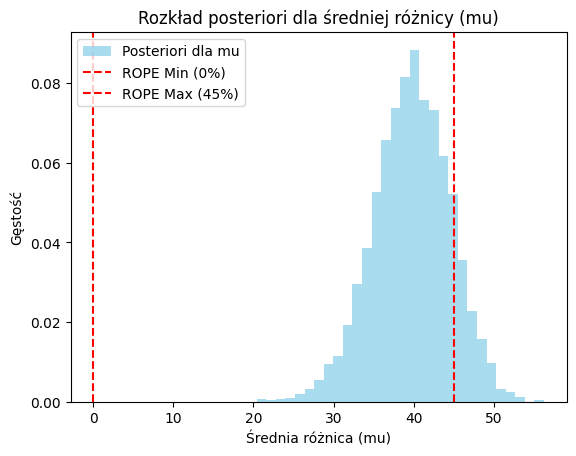

Srednia po modyfikacji: 56.1183078917654


In [26]:
    
scores_after_change  = score_dataset(python_filenames, watermarked_path, changed_path, WATERMARK)
after_scores = []    

print("\nScores after modification:")
for file, score in scores_after_change:
    print(f"{file}: {score if score is not None else 'No file found'}%")
    if score is not None:
        after_scores.append(score)
        
        
if len(before_change_scores) == len(after_scores) == len(before_scores):
    sum_before_change = np.array(before_change_scores) + np.array(before_scores) 
    diff = ( sum_before_change - np.array(after_scores)) / ((sum_before_change) / 100)
    perform_stats(diff)
else:
    print("Nie można obliczyć różnic - różna liczba wyników przed i po modyfikacji.")
    
    

print("Srednia po modyfikacji: " + str(np.mean(after_scores)))   
#DATASET DATASET DATASET DATASET DATASET DATASET DATASET DATASET
################################################################

Srednia przed bez watermark(%)     : 10.962805523398972 \
Srednia watermark(%)               : 99.46666666666667 \
Srednia po modyfikacji watermark(%): 56.1183078917654

10.96 + 99.46 =~ 110/2 = 55 
Uwzgledniajac te wartosci ustawiamy ROPE na [0,45], czyli uważamy, że kod który ma 55% i więcej watermarka jest naszym kodem.
Do obliczenia różnicy posługujemy się wzorem
```
    sum_before_change = np.array(before_change_scores) + np.array(before_scores) 
    diff = ( sum_before_change - np.array(after_scores)) / ((sum_before_change) / 100)
```

Kody po zwatermarkowaniu zostaly zmienione nastepujaco: 
- 1.py     - Test
- 2-11.py  - Automatyczny refactor(Intellij)
- 12-16.py - Segregacja import/from
- 17-19.py - Te same pliki inaczej zmodyfikowane, kazda technika jest inaczej ważona
- 20-22.py - Pełne cleancode (automatyczny refactory, sortowanie, usuwanie komentarzy), mimo to zostaje 18%
- 23-26.py - Poprawki wskazane przez IDE(nazwy funkcji klas, nieuzywane importy)
- 27-30.py - Drobne poprawki lub brak
    

Otrzymujemy następujące wyniki:
```
Prawdopodobieństwo, że zmiana mieści się w ROPE (0, 45): 86.35%
Prawdopodobieństwo, że zmiana jest istotna: 13.65%
```    